# Reinforcement Learning with Tic-Tac-Toe

This notebook demonstrates key reinforcement learning concepts using the classic game of tic-tac-toe as an example.

## What is Reinforcement Learning?

Reinforcement Learning (RL) is a type of machine learning where an agent learns to make decisions by interacting with an environment. The agent receives rewards or penalties for its actions and learns to maximize cumulative rewards over time.

### Key Components:
- **Agent**: The learner/decision maker
- **Environment**: The world the agent interacts with
- **State**: Current situation of the agent
- **Action**: What the agent can do
- **Reward**: Feedback from the environment
- **Policy**: Strategy that maps states to actions

In [1]:
import numpy as np
import random
from collections import defaultdict
import matplotlib.pyplot as plt

## Tic-Tac-Toe Environment

Let's create a simple tic-tac-toe environment where our RL agent can learn to play.

In [2]:
class TicTacToe:
    def __init__(self):
        self.board = np.zeros((3, 3), dtype=int)
        self.current_player = 1  # 1 for X, -1 for O
        
    def reset(self, random_start=False):
        self.board = np.zeros((3, 3), dtype=int)
        if random_start:
            self.current_player = random.choice([1, -1])
        else:
            self.current_player = 1
        return self.get_state()
    
    def get_state(self):
        # Convert board to a string representation for use as dictionary key
        return str(self.board.flatten())
    
    def get_valid_actions(self):
        # Return list of valid positions (empty squares)
        valid_actions = []
        for i in range(3):
            for j in range(3):
                if self.board[i, j] == 0:
                    valid_actions.append((i, j))
        return valid_actions
    
    def make_move(self, action):
        row, col = action
        if self.board[row, col] != 0:
            return False  # Invalid move
        
        self.board[row, col] = self.current_player
        return True
    
    def check_winner(self):
        # Check rows, columns, and diagonals
        for i in range(3):
            if abs(sum(self.board[i, :])) == 3:
                return self.board[i, 0]
            if abs(sum(self.board[:, i])) == 3:
                return self.board[0, i]
        
        # Check diagonals
        if abs(sum([self.board[i, i] for i in range(3)])) == 3:
            return self.board[0, 0]
        if abs(sum([self.board[i, 2-i] for i in range(3)])) == 3:
            return self.board[0, 2]
        
        return 0  # No winner
    
    def is_game_over(self):
        return self.check_winner() != 0 or len(self.get_valid_actions()) == 0
    
    def get_reward(self, player):
        winner = self.check_winner()
        if winner == player:
            return 1  # Win
        elif winner == -player:
            return -1  # Loss
        else:
            return 0  # Draw or game not over
    
    def display(self):
        symbols = {0: ' ', 1: 'X', -1: 'O'}
        print("\n   0   1   2")
        for i in range(3):
            print(f"{i}  {symbols[self.board[i,0]]} | {symbols[self.board[i,1]]} | {symbols[self.board[i,2]]}")
            if i < 2:
                print("  -----------")
        print()

## Q-Learning Agent

Q-Learning is a model-free reinforcement learning algorithm that learns the quality of actions, telling an agent what action to take under what circumstances.

### Mathematical Foundation

**Bellman Equation for Q-Values:**

The optimal Q-function satisfies the Bellman optimality equation:
```
Q*(s,a) = E[r + γ·max Q*(s',a') | s,a]
```

This states that the optimal Q-value for state-action pair (s,a) equals the expected immediate reward plus the discounted maximum Q-value of the next state.

**From Bellman to Q-Learning:**

1. **Bellman Equation** (theoretical optimum):
   ```
   Q*(s,a) = E[r + γ·max Q*(s',a')]
   ```

2. **Sample-based approximation** (replace expectation with sample):
   ```
   Q(s,a) ≈ r + γ·max Q(s',a')
   ```

3. **Iterative update** (gradually adjust towards target):
   ```
   Q(s,a) ← Q(s,a) + α[Target - Current]
   Q(s,a) ← Q(s,a) + α[r + γ·max Q(s',a') - Q(s,a)]
   ```

**Q-Learning Update Rule:**
```
Q(s,a) ← Q(s,a) + α[r + γ·max Q(s',a') - Q(s,a)]
```

Where:
- **Q(s,a)**: Quality value for taking action `a` in state `s`
- **α (alpha)**: Learning rate ∈ [0,1] - controls how much new information overrides old
- **γ (gamma)**: Discount factor ∈ [0,1] - importance of future rewards
- **r**: Immediate reward received
- **s'**: Next state after taking action `a`
- **max Q(s',a')**: Maximum Q-value among all possible actions in next state

**Temporal Difference Error:**
```
δ = r + γ·max Q(s',a') - Q(s,a)
```

This error represents the difference between the Bellman target and current estimate, driving convergence to the optimal Q-function.

### Q-Table Structure and State Representation

**What is the Q-Table?**
The Q-table is a lookup table that stores quality values for state-action pairs:
```python
Q[state][action] = expected_reward
```

**State Representation:**
- **State**: Current board configuration only (not history)
- **Format**: String representation of flattened 3x3 board
- **Example**: `"[0 0 0 0 1 0 0 0 0]"` (X in center, rest empty)
- **Values**: 0=empty, 1=X, -1=O

**Important Properties:**
- **Markovian**: Only current board state matters for optimal play
- **Sparse**: Q-table only contains states encountered during training (~3000 out of 19,683 possible)
- **Valid Only**: No invalid states (like too many X's) are stored
- **Dynamic Growth**: Q-table starts empty and grows during training

**Q-Values vs Probabilities:**
- **Q-values**: Expected future reward (can be negative, positive, or zero)
- **NOT probabilities**: Q-values represent quality, not likelihood
- **Action selection**: Uses epsilon-greedy policy to convert Q-values to actions

### Epsilon-Greedy Policy and Learning Evolution

**Epsilon-Greedy Strategy:**
```
π(s) = {
  random action with probability ε (exploration)
  argmax Q(s,a) with probability 1-ε (exploitation)
}
```

**Epsilon Decay During Training:**
- **Initial**: ε = 0.1 (10% random exploration)
- **Decay**: ε = ε × 0.995 after each episode
- **Minimum**: ε = 0.01 (1% random, never goes to zero)
- **Purpose**: Balance exploration (learning) vs exploitation (using knowledge)

**Training vs Playing Behavior:**
- **During Training**: Uses epsilon-greedy (some randomness for learning)
- **When Playing**: Sets ε = 0 (pure greedy, no randomness, optimal play)

### Key Concepts:
- **Q-Table**: Stores quality values for state-action pairs
- **Exploration vs Exploitation**: Balance between trying new actions and using known good actions
- **Learning Rate (α)**: How much new information overrides old information (0.1 in our implementation)
- **Discount Factor (γ)**: Importance of future rewards (0.9 in our implementation)
- **Epsilon (ε)**: Probability of taking random action for exploration (starts at 0.1, decays to 0.01 over time)

In [3]:
class QLearningAgent:
    def __init__(self, learning_rate=0.1, discount_factor=0.9, epsilon=0.1):
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.q_table = defaultdict(lambda: defaultdict(float))
        self.player = 1  # This agent plays as X
        
    def get_action(self, state, valid_actions):
        # Epsilon-greedy action selection
        if random.random() < self.epsilon:
            # Exploration: choose random action
            return random.choice(valid_actions)
        else:
            # Exploitation: choose best known action
            q_values = [self.q_table[state][action] for action in valid_actions]
            max_q = max(q_values)
            # If multiple actions have the same max Q-value, choose randomly among them
            best_actions = [action for action, q in zip(valid_actions, q_values) if q == max_q]
            return random.choice(best_actions)
    
    def update_q_table(self, state, action, reward, next_state, next_valid_actions):
        # Q-Learning update rule
        current_q = self.q_table[state][action]
        
        if next_valid_actions:
            # Game continues, consider future rewards
            max_next_q = max([self.q_table[next_state][next_action] for next_action in next_valid_actions])
        else:
            # Game over, no future rewards
            max_next_q = 0
        
        # Q(s,a) = Q(s,a) + α[r + γ*max(Q(s',a')) - Q(s,a)]
        new_q = current_q + self.learning_rate * (reward + self.discount_factor * max_next_q - current_q)
        self.q_table[state][action] = new_q
    
    def decay_epsilon(self, decay_rate=0.995):
        self.epsilon = max(0.01, self.epsilon * decay_rate)

## Random Opponent

Let's create a simple random opponent for our agent to play against.

In [4]:
class RandomAgent:
    def __init__(self):
        self.player = -1  # This agent plays as O
    
    def get_action(self, state, valid_actions):
        return random.choice(valid_actions)

## Training the Agent

Now let's train our Q-learning agent by having it play many games against the random opponent.

### Training Process Explanation

**What happens during training:**

1. **Random Starting Player**: Each episode randomly chooses who goes first
   - ~50% of games: Q-agent starts first (learns opening strategies)
   - ~50% of games: Q-agent starts second (learns defensive responses)

2. **Game Play**: Agent and opponent alternate moves until game ends

3. **Experience Collection**: Store all moves made by Q-agent: (state, action, player)

4. **Reward Assignment**: At game end, assign rewards:
   - Win: +1 reward
   - Loss: -1 reward
   - Draw: 0 reward

5. **Q-Table Updates**: Update Q-values for all Q-agent moves using Q-learning rule

6. **Epsilon Decay**: Reduce exploration probability (ε = ε × 0.995)

**Learning Evolution:**
- **Early Training**: High exploration (ε ≈ 0.1), discovering strategies
- **Mid Training**: Balanced exploration/exploitation, learning tactics
- **Late Training**: Low exploration (ε ≈ 0.01), refining optimal play

**What the Agent Learns:**
- **Strategic Patterns**: Center and corner moves are strong
- **Tactical Knowledge**: Block opponent's winning moves, take own winning moves
- **Positional Understanding**: Creating forks and multiple threats
- **Defensive Skills**: Counter-strategies when playing second

In [5]:
def train_agent(episodes=10000):
    env = TicTacToe()
    q_agent = QLearningAgent()
    random_agent = RandomAgent()
    
    wins = 0
    losses = 0
    draws = 0
    
    win_history = []
    first_player_games = 0  # Track when Q-agent goes first
    
    for episode in range(episodes):
        state = env.reset(random_start=True)  # Randomly choose starting player
        game_history = []  # Store (state, action, reward) for batch updates
        
        # Track if Q-agent starts first
        if env.current_player == q_agent.player:
            first_player_games += 1
        
        while not env.is_game_over():
            valid_actions = env.get_valid_actions()
            
            if env.current_player == q_agent.player:  # Q-learning agent's turn
                action = q_agent.get_action(state, valid_actions)
                env.make_move(action)
                
                # Store state-action pair for later update
                game_history.append((state, action, env.current_player))
                
            else:  # Random agent's turn
                action = random_agent.get_action(state, valid_actions)
                env.make_move(action)
            
            env.current_player *= -1  # Switch players
            state = env.get_state()
        
        # Game over, calculate rewards and update Q-table
        final_reward = env.get_reward(q_agent.player)
        
        # Update Q-values for all moves made by the Q-learning agent
        for i, (hist_state, hist_action, player) in enumerate(game_history):
            if player == q_agent.player:
                if i < len(game_history) - 1:
                    next_state = game_history[i + 1][0] if i + 1 < len(game_history) else state
                    next_valid_actions = env.get_valid_actions() if not env.is_game_over() else []
                else:
                    next_state = state
                    next_valid_actions = []
                
                q_agent.update_q_table(hist_state, hist_action, final_reward, next_state, next_valid_actions)
        
        # Track results
        if final_reward == 1:
            wins += 1
        elif final_reward == -1:
            losses += 1
        else:
            draws += 1
        
        # Decay epsilon for less exploration over time
        q_agent.decay_epsilon()
        
        # Track win rate every 1000 episodes
        if (episode + 1) % 1000 == 0:
            win_rate = wins / (episode + 1)
            first_player_rate = first_player_games / (episode + 1)
            win_history.append(win_rate)
            print(f"Episode {episode + 1}: Win rate = {win_rate:.3f}, First player rate = {first_player_rate:.3f}, Epsilon = {q_agent.epsilon:.3f}")
    
    print(f"\nFinal Results after {episodes} episodes:")
    print(f"Wins: {wins} ({wins/episodes:.1%})")
    print(f"Losses: {losses} ({losses/episodes:.1%})")
    print(f"Draws: {draws} ({draws/episodes:.1%})")
    print(f"Q-agent went first: {first_player_games} times ({first_player_games/episodes:.1%})")
    
    return q_agent, win_history

In [ ]:
# Train the agent with random starting player
trained_agent, win_history = train_agent(100000)

Episode 1000: Win rate = 0.582, First player rate = 0.487, Epsilon = 0.010
Episode 2000: Win rate = 0.653, First player rate = 0.486, Epsilon = 0.010
Episode 3000: Win rate = 0.687, First player rate = 0.488, Epsilon = 0.010
Episode 4000: Win rate = 0.707, First player rate = 0.483, Epsilon = 0.010
Episode 5000: Win rate = 0.720, First player rate = 0.490, Epsilon = 0.010
Episode 6000: Win rate = 0.734, First player rate = 0.492, Epsilon = 0.010
Episode 7000: Win rate = 0.747, First player rate = 0.493, Epsilon = 0.010
Episode 8000: Win rate = 0.757, First player rate = 0.493, Epsilon = 0.010
Episode 9000: Win rate = 0.768, First player rate = 0.495, Epsilon = 0.010
Episode 10000: Win rate = 0.773, First player rate = 0.495, Epsilon = 0.010
Episode 11000: Win rate = 0.779, First player rate = 0.495, Epsilon = 0.010
Episode 12000: Win rate = 0.782, First player rate = 0.496, Epsilon = 0.010
Episode 13000: Win rate = 0.787, First player rate = 0.497, Epsilon = 0.010
Episode 14000: Win ra

## Visualizing Learning Progress

Let's plot how the agent's performance improved over time.

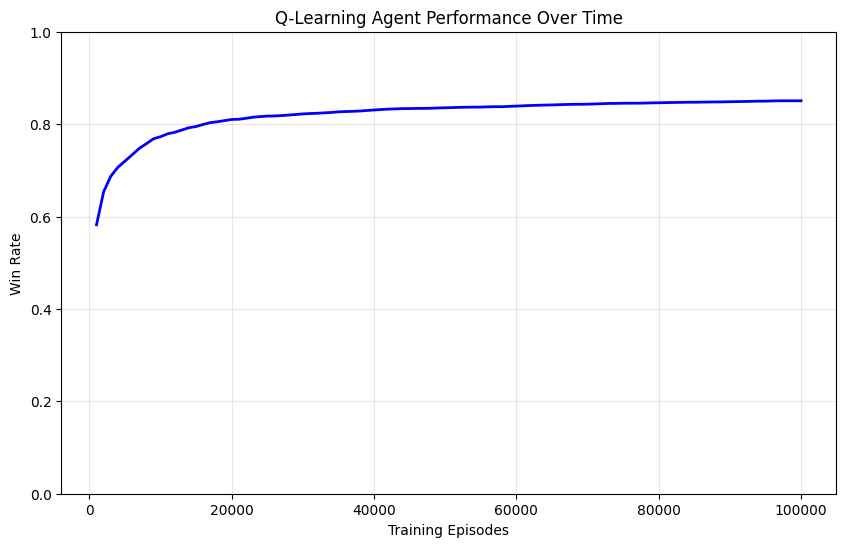

Final win rate: 85.1%


In [8]:
# Plot the learning curve
plt.figure(figsize=(10, 6))
episodes = range(1000, len(win_history) * 1000 + 1, 1000)
plt.plot(episodes, win_history, 'b-', linewidth=2)
plt.title('Q-Learning Agent Performance Over Time')
plt.xlabel('Training Episodes')
plt.ylabel('Win Rate')
plt.grid(True, alpha=0.3)
plt.ylim(0, 1)
plt.show()

print(f"Final win rate: {win_history[-1]:.1%}")

## Testing the Trained Agent

Let's test our trained agent by having it play a few games and see how it performs.

In [9]:
def test_agent(agent, num_games=100):
    env = TicTacToe()
    random_opponent = RandomAgent()
    
    # Set epsilon to 0 for testing (no exploration, only exploitation)
    original_epsilon = agent.epsilon
    agent.epsilon = 0
    
    wins = 0
    losses = 0
    draws = 0
    
    for game in range(num_games):
        state = env.reset()
        
        while not env.is_game_over():
            valid_actions = env.get_valid_actions()
            
            if env.current_player == 1:  # Agent's turn
                action = agent.get_action(state, valid_actions)
            else:  # Random opponent's turn
                action = random_opponent.get_action(state, valid_actions)
            
            env.make_move(action)
            env.current_player *= -1
            state = env.get_state()
        
        result = env.get_reward(agent.player)
        if result == 1:
            wins += 1
        elif result == -1:
            losses += 1
        else:
            draws += 1
    
    # Restore original epsilon
    agent.epsilon = original_epsilon
    
    print(f"Test Results over {num_games} games:")
    print(f"Wins: {wins} ({wins/num_games:.1%})")
    print(f"Losses: {losses} ({losses/num_games:.1%})")
    print(f"Draws: {draws} ({draws/num_games:.1%})")
    
    return wins, losses, draws

In [10]:
# Test the trained agent
test_results = test_agent(trained_agent, 1000)

Test Results over 1000 games:
Wins: 941 (94.1%)
Losses: 0 (0.0%)
Draws: 59 (5.9%)


## Play Against the Agent

Let's create a function to play against our trained agent interactively.

### Agent Playing Behavior

**Important Note**: When playing against you, the agent uses a **pure greedy policy**:
- **Epsilon set to 0**: No random exploration during gameplay
- **Optimal Play**: Always chooses the action with highest Q-value
- **Maximum Challenge**: Agent plays at its full learned capability

This differs from training where the agent used epsilon-greedy (some randomness) to learn new strategies.

In [11]:
def play_against_agent(agent):
    env = TicTacToe()
    
    # Set epsilon to 0 for playing (no exploration)
    original_epsilon = agent.epsilon
    agent.epsilon = 0
    
    print("🎮 Welcome to Tic-Tac-Toe!")
    print("You are O (circles), the agent is X (crosses)")
    print("\nBoard positions:")
    print("  1 | 2 | 3")
    print("  ---------")
    print("  4 | 5 | 6") 
    print("  ---------")
    print("  7 | 8 | 9")
    print("\nJust enter a number 1-9 to make your move!\n")
    
    # Position mapping: number -> (row, col)
    pos_map = {
        1: (0,0), 2: (0,1), 3: (0,2),
        4: (1,0), 5: (1,1), 6: (1,2),
        7: (2,0), 8: (2,1), 9: (2,2)
    }
    
    # Reverse mapping: (row, col) -> number
    reverse_map = {v: k for k, v in pos_map.items()}
    
    state = env.reset()
    env.display()
    
    while not env.is_game_over():
        valid_actions = env.get_valid_actions()
        
        if env.current_player == 1:  # Agent's turn (X)
            print("🤖 Agent's turn...")
            action = agent.get_action(state, valid_actions)
            env.make_move(action)
            agent_pos = reverse_map[action]
            print(f"Agent chose position {agent_pos}")
            
        else:  # Human player's turn (O)
            print("👤 Your turn!")
            valid_numbers = [reverse_map[action] for action in valid_actions]
            print(f"Available positions: {sorted(valid_numbers)}")
            
            try:
                move_input = input("Enter position (1-9): ")
                position = int(move_input)
                
                if position in valid_numbers:
                    action = pos_map[position]
                    env.make_move(action)
                else:
                    print("❌ Invalid move! Position already taken or out of range.")
                    continue
                    
            except ValueError:
                print("❌ Invalid input! Please enter a number 1-9.")
                continue
        
        env.current_player *= -1
        state = env.get_state()
        env.display()
    
    # Game over, announce result
    winner = env.check_winner()
    if winner == 1:
        print("🤖 Agent wins!")
    elif winner == -1:
        print("🎉 You win!")
    else:
        print("🤝 It's a draw!")
    
    # Restore original epsilon
    agent.epsilon = original_epsilon

In [ ]:
# Play against the trained agent!
play_against_agent(trained_agent)

🎮 Welcome to Tic-Tac-Toe!
You are O (circles), the agent is X (crosses)

Board positions:
  1 | 2 | 3
  ---------
  4 | 5 | 6
  ---------
  7 | 8 | 9

Just enter a number 1-9 to make your move!


   0   1   2
0    |   |  
  -----------
1    |   |  
  -----------
2    |   |  

🤖 Agent's turn...
Agent chose position 5

   0   1   2
0    |   |  
  -----------
1    | X |  
  -----------
2    |   |  

👤 Your turn!
Available positions: [1, 2, 3, 4, 6, 7, 8, 9]


## Key Takeaways

This notebook demonstrated several important reinforcement learning concepts:

1. **Environment Design**: We created a tic-tac-toe environment that provides states, actions, and rewards.

2. **Q-Learning Algorithm**: Our agent learned by updating Q-values based on the reward received and the maximum future reward possible.

3. **Exploration vs Exploitation**: The epsilon-greedy strategy balanced trying new actions (exploration) with using known good actions (exploitation).

4. **Learning Over Time**: The agent's performance improved as it played more games and learned better strategies.

5. **Hyperparameter Tuning**: Learning rate, discount factor, and epsilon decay all affect the agent's learning performance.

## Extensions to Try

- Implement different RL algorithms (SARSA, Deep Q-Networks)
- Train against different types of opponents (minimax, human players)
- Experiment with different reward structures
- Add more sophisticated state representations
- Implement self-play training

This example provides a solid foundation for understanding how reinforcement learning works in practice!